In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from utils.data import load_tc_data
from utils.plot import make_cmap

In [2]:
def calc_nyears(meta):
	nyears = int(meta.year[len(meta.year)-1] - meta.year[0] + 1)
	return nyears

In [3]:
# load dataset
# load data
def generate_composite_rainfall(meta,rain,ibtracks=False,time_sample_rate=False,rain_rate=False,imerg=False):
	
	

	# get subset of storms
	sids = meta.sid
	# if hist == True:
	# 	bool = [yr in range(2069,2100) for yr in meta.year]
	# 	print(bool)
	# 	sids = meta.loc[bool, 'sid']
	# 	print(sids)
	sids_unique=sids.drop_duplicates()
	nstorms = len(sids_unique)
	# avg_timesteps = len(sids)/nstorms
	tracks_grouped = meta.groupby('sid')
	composite_storm_rain = np.zeros((nstorms,100,100))
	i=0
	drop_idx=[]
	south_idx=[]
	north_idx=[]
	# find time frequency
	for sid in sids_unique:
		storm = tracks_grouped.get_group(sid)
		if ibtracks != False:
			storm_full = ibtracks.get_group(sid)
		else:
			storm_full = storm

		if time_sample_rate==False:
			
			hourly_rate=[]
			print(storm_full)
			for h in storm_full.hour:
				if h in [3,9,15,21]:
					hour_rate = 3
				elif h in [0,6,12,18]:
					hour_rate = 6
				else:
					hour_rate = 0
				
				hourly_rate.append(hour_rate)

			# calculate hourly rates
			if set(hourly_rate) == {3,6}:
				# calculate storm duration as time rate (3 or 6 hourly time points) * number of time points
				storm_duration = 3 * len(storm) # this gives how many hours storm was alive for as a TC
				# define unit converstion as rain/storm_duration (number of hours) * 24 to get daily rain rate
				units_converter = 24/storm_duration

			elif 6 in set(hourly_rate): # so this means one datapoint every 6 hours
				storm_duration = 6 * len(storm) # this gives how many hours storm was alive for as a TC
				# need to multiply the rain by 2 because units are mm/3h, right now only accounting for half the rain, so multiplying by 2 is interpolating for rain between values
				units_converter = 24 * 2/storm_duration
				
			else:
				print('storm set is strange')
				print(set(hourly_rate))
				units_converter = 0
		else:
			
			storm_duration = time_sample_rate * len(storm)
			# if rain_rate == False: # if rain is sampled at same time as track
			units_converter = 24 / storm_duration
			# else: # otherwise rain is counted 3 hourly so needs to be doubled as tracks are counted 6 hourly so we're missing out on half the rain
			# 	units_converter = 24*rain_rate / storm_duration
			# TODO: maybe this needs to be average rain per day not total rain added up then divided by number of days.
			# so instead of 24/storm_duration which would be smaller for longer storms?
			# it would be or maybe it's correct
			# 
		# # rain_rate is applied if storms are 3 hourly not 6 hourly, so rain rate is doubled becuase we are only counting 6 hourly
		# but then rain is mm/hr so actually we add up over the 6 hour track time so don't need to worry about this.
		# if rain_rate != False:
		# 	unites_converter = rain_rate * unites_converter
		if imerg == True:
			units_converter = 3 * units_converter
		storm_lats = storm.centre_lat
		storm_lons = storm.centre_lon
		# print(storm.index)
		storm_rain = rain[storm.index,:,:,0]
		# remove negative rain?
		storm_rain[storm_rain < 0] = 0
		
		# rain_data = rain_data * 86400/4 don't forget original cmip6 data was in precip flux units, so I converted to mm/6hr
		mean_storm_rain = np.sum(storm_rain,axis=0)*units_converter
		# storm_month = storm.month
		# storm_year = storm.year
		# storm_v = storm.v
		if units_converter == 0:
			drop_idx.append(i)
		else:
			if np.sum(storm_lats) < 0:
				south_idx.append(i)
			else:
				north_idx.append(i)
		

		composite_storm_rain[i,:,:] = mean_storm_rain
		i=i+1

	# save plottable dataset
	# composite_rainfall = calculate_composite_rainfall()
	# delete timestamps we can't use
	# np.delete(composite_storm_rain,drop_idx,axis=0)
	# get nh and sh datasets
	composite_storm_rain_nh = composite_storm_rain[north_idx,:,:]
	composite_storm_rain_sh = composite_storm_rain[south_idx,:,:]
	# print(composite_storm_rain.shape)
	# print(composite_storm_rain_nh.shape)
	# print(composite_storm_rain_sh.shape)
	composite_nh = np.mean(composite_storm_rain_nh,axis=0)
	composite_sh = np.mean(composite_storm_rain_sh,axis=0)
	return composite_nh,composite_sh,len(north_idx),len(south_idx)




In [4]:
# tracks = pd.read_csv('/user/work/al18709/ibtracks/ibtracs.ALL.list.v04r00.csv',
# 						usecols=['SID','LAT','LON','BASIN','NAME','SEASON', 'NATURE','ISO_TIME','USA_SSHS'],
# 						parse_dates = ['ISO_TIME'],keep_default_na=False)

# # tidy up columns with multiple dtypes
# tracks = tracks.iloc[1: , :]
# tracks = tracks.replace(' ', np.nan)
# tracks['USA_SSHS'] = pd.to_numeric(tracks['USA_SSHS'])
# tracks['SEASON'] = pd.to_numeric(tracks['SEASON'])

# tracks = tracks[tracks['SEASON'] >= 2000]
# tracks = tracks[tracks['SEASON'] <= 2014]


# TCs = tracks[tracks['USA_SSHS'] >= 1]['SID']
# TCs = TCs.drop_duplicates()
# print('number of TCs: ', len(TCs))
# # reference tracks with TCs
# tracks = pd.merge(tracks, 
#                       TCs, 
#                       on ='SID', 
#                       how ='inner')
# # tracks = tracks[tracks['USA_SSHS'] >= 1]
# tracks = tracks[tracks['USA_SSHS'] >= 0]

In [5]:
# intersection_storms = set(mswep_sids['sid'].drop_duplicates())& set(imerg_sids['sid'].drop_duplicates())
# print(len(intersection_storms))
# print(np.array(intersection_storms))
# storms = []
# for s in intersection_storms:
#     storms.append(s)

# print(np.sort(storms))

# outlier_storms = set(mswep_sids['sid'].drop_duplicates()) - set(imerg_sids['sid'].drop_duplicates())
# print(len(outlier_storms))
# print(np.array(outlier_storms))
# storms = []
# for s in outlier_storms:
#     storms.append(s)

# print(np.sort(storms))

In [6]:

# load ibtracks
tracks = pd.read_csv('/user/home/al18709/work/ibtracks/tc_files.csv')
og_tracks_grouped = tracks.groupby('sid')


# load imerg
imerg_rain = np.load('/user/home/al18709/work/CMIP6/IMERG-V07/storm_rain/storm_rain_NH.npy')
imerg_lats = np.load('/user/home/al18709/work/CMIP6/IMERG-V07/storm_rain/storm_lats_NH.npy')
imerg_lons = np.load('/user/home/al18709/work/CMIP6/IMERG-V07/storm_rain/storm_lons_NH.npy')
imerg_sids = pd.read_csv('/user/home/al18709/work/CMIP6/IMERG-V07/storm_rain/storm_sid_NH.csv')
indices = (imerg_sids['year'] >= 2000) & (imerg_sids['year'] <= 2014)
imerg_sids = imerg_sids[indices].reset_index()
imerg_rain = imerg_rain[indices]
imerg_lats = imerg_lats[indices]
imerg_lons = imerg_lons[indices]
meta_imerg = pd.DataFrame({'sid':imerg_sids.sid ,'centre_lat':imerg_lats[:,4], 'centre_lon':imerg_lons[:,4], 'hour':imerg_sids.hour, 'year':imerg_sids.year})

# load mswep
mswep_rain = np.load('/user/home/al18709/work/CMIP6/MSWEP/storm_rain/storm_rain_NH.npy')
mswep_lats = np.load('/user/home/al18709/work/CMIP6/MSWEP/storm_rain/storm_lats_NH.npy')
mswep_lons = np.load('/user/home/al18709/work/CMIP6/MSWEP/storm_rain/storm_lons_NH.npy')
mswep_sids = pd.read_csv('/user/home/al18709/work/CMIP6/MSWEP/storm_rain/storm_sid_NH.csv')
indices = (mswep_sids['year'] >= 2000) & (mswep_sids['year'] <= 2014)
mswep_sids = mswep_sids[indices].reset_index()
mswep_rain = mswep_rain[indices]
mswep_lats = mswep_lats[indices]
mswep_lons = mswep_lons[indices]
meta_mswep = pd.DataFrame({'sid':mswep_sids.sid ,'centre_lat':mswep_lats[:,4], 'centre_lon':mswep_lons[:,4], 'hour':mswep_sids.hour, 'year':mswep_sids.year})


# load HighResMIP CMCC-CM2-VHR4 historical NH
CMCC_hist_NH_rain = np.load('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/historical/storm_rain_NH.npy')
CMCC_hist_NH_lats = np.load('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/historical/storm_lats_NH.npy')
CMCC_hist_NH_lons = np.load('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/historical/storm_lons_NH.npy')
CMCC_hist_NH_sids = pd.read_csv('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/historical/storm_sid_NH.csv')
print(CMCC_hist_NH_sids.sid.shape)
indices = (CMCC_hist_NH_sids['year'] >= 2000) & (CMCC_hist_NH_sids['year'] <= 2014)
CMCC_hist_NH_sids = CMCC_hist_NH_sids[indices].reset_index()
CMCC_hist_NH_rain = CMCC_hist_NH_rain[indices]
CMCC_hist_NH_lats = CMCC_hist_NH_lats[indices]
CMCC_hist_NH_lons = CMCC_hist_NH_lons[indices]
meta_CMCC_hist_NH = pd.DataFrame({'sid':CMCC_hist_NH_sids.sid ,'centre_lat':CMCC_hist_NH_lats[:,4], 'centre_lon':CMCC_hist_NH_lons[:,4], 'year':CMCC_hist_NH_sids.year})

# load HighResMIP CMCC-CM2-VHR4 historical SH
CMCC_hist_SH_rain = np.load('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/historical/storm_rain_SH.npy')
CMCC_hist_SH_lats = np.load('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/historical/storm_lats_SH.npy')
CMCC_hist_SH_lons = np.load('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/historical/storm_lons_SH.npy')
CMCC_hist_SH_sids = pd.read_csv('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/historical/storm_sid_SH.csv')
print(CMCC_hist_SH_sids.sid.shape)
indices = (CMCC_hist_SH_sids['year'] >= 2000) & (CMCC_hist_SH_sids['year'] <= 2014)
CMCC_hist_SH_sids = CMCC_hist_SH_sids[indices].reset_index()
CMCC_hist_SH_rain = CMCC_hist_SH_rain[indices]
CMCC_hist_SH_lats = CMCC_hist_SH_lats[indices]
CMCC_hist_SH_lons = CMCC_hist_SH_lons[indices]
meta_CMCC_hist_SH = pd.DataFrame({'sid':CMCC_hist_SH_sids.sid ,'centre_lat':CMCC_hist_SH_lats[:,4], 'centre_lon':CMCC_hist_SH_lons[:,4], 'year':CMCC_hist_SH_sids.year})

# load HighResMIP EC-EARTH-3P-HR  historical NH
ecearthhr_hist_NH_rain = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3P-HR/storm_rain/historical/storm_rain_NH.npy')
ecearthhr_hist_NH_lats = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3P-HR/storm_rain/historical/storm_lats_NH.npy')
ecearthhr_hist_NH_lons = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3P-HR/storm_rain/historical/storm_lons_NH.npy')
ecearthhr_hist_NH_sids = pd.read_csv('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3P-HR/storm_rain/historical/storm_sid_NH.csv')
print(ecearthhr_hist_NH_sids.sid.shape)
indices = (ecearthhr_hist_NH_sids['year'] >= 2000) & (ecearthhr_hist_NH_sids['year'] <= 2014)
ecearthhr_hist_NH_sids = ecearthhr_hist_NH_sids[indices].reset_index()
ecearthhr_hist_NH_rain = ecearthhr_hist_NH_rain[indices]
ecearthhr_hist_NH_lats = ecearthhr_hist_NH_lats[indices]
ecearthhr_hist_NH_lons = ecearthhr_hist_NH_lons[indices]
meta_ecearthhr_hist_NH = pd.DataFrame({'sid':ecearthhr_hist_NH_sids.sid ,'centre_lat':ecearthhr_hist_NH_lats[:,4], 'centre_lon':ecearthhr_hist_NH_lons[:,4], 'year':ecearthhr_hist_NH_sids.year})

# load HighResMIP EC-EARTH-3P-HR historical SH
ecearthhr_hist_SH_rain = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3P-HR/storm_rain/historical/storm_rain_SH.npy')
ecearthhr_hist_SH_lats = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3P-HR/storm_rain/historical/storm_lats_SH.npy')
ecearthhr_hist_SH_lons = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3P-HR/storm_rain/historical/storm_lons_SH.npy')
ecearthhr_hist_SH_sids = pd.read_csv('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3P-HR/storm_rain/historical/storm_sid_SH.csv')
print(ecearthhr_hist_SH_sids.sid.shape)
indices = (ecearthhr_hist_SH_sids['year'] >= 2000) & (ecearthhr_hist_SH_sids['year'] <= 2014)
ecearthhr_hist_SH_sids = ecearthhr_hist_SH_sids[indices].reset_index()
ecearthhr_hist_SH_rain = ecearthhr_hist_SH_rain[indices]
ecearthhr_hist_SH_lats = ecearthhr_hist_SH_lats[indices]
ecearthhr_hist_SH_lons = ecearthhr_hist_SH_lons[indices]
meta_ecearthhr_hist_SH = pd.DataFrame({'sid':ecearthhr_hist_SH_sids.sid ,'centre_lat':ecearthhr_hist_SH_lats[:,4], 'centre_lon':ecearthhr_hist_SH_lons[:,4], 'year':ecearthhr_hist_SH_sids.year})

# load HighResMIP HadGEM3-GC31-HM   historical NH
hadgem_hist_NH_rain = np.load('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/historical/storm_rain_NH.npy')
hadgem_hist_NH_lats = np.load('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/historical/storm_lats_NH.npy')
hadgem_hist_NH_lons = np.load('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/historical/storm_lons_NH.npy')
hadgem_hist_NH_sids = pd.read_csv('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/historical/storm_sid_NH.csv')
print(hadgem_hist_NH_sids.sid.shape)
indices = (hadgem_hist_NH_sids['year'] >= 2000) & (hadgem_hist_NH_sids['year'] <= 2014)
hadgem_hist_NH_sids = hadgem_hist_NH_sids[indices].reset_index()
hadgem_hist_NH_rain = hadgem_hist_NH_rain[indices]
hadgem_hist_NH_lats = hadgem_hist_NH_lats[indices]
hadgem_hist_NH_lons = hadgem_hist_NH_lons[indices]
meta_hadgem_hist_NH = pd.DataFrame({'sid':hadgem_hist_NH_sids.sid ,'centre_lat':hadgem_hist_NH_lats[:,4], 'centre_lon':hadgem_hist_NH_lons[:,4], 'year':hadgem_hist_NH_sids.year})

# # load HighResMIP HadGEM3-GC31-HM  historical SH
hadgem_hist_SH_rain = np.load('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/historical/storm_rain_SH.npy')
hadgem_hist_SH_lats = np.load('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/historical/storm_lats_SH.npy')
hadgem_hist_SH_lons = np.load('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/historical/storm_lons_SH.npy')
hadgem_hist_SH_sids = pd.read_csv('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/historical/storm_sid_SH.csv')
print(hadgem_hist_SH_sids.sid.shape)
indices = (hadgem_hist_SH_sids['year'] >= 2000) & (hadgem_hist_SH_sids['year'] <= 2014)
hadgem_hist_SH_sids = hadgem_hist_SH_sids[indices].reset_index()
hadgem_hist_SH_rain = hadgem_hist_SH_rain[indices]
hadgem_hist_SH_lats = hadgem_hist_SH_lats[indices]
hadgem_hist_SH_lons = hadgem_hist_SH_lons[indices]
meta_hadgem_hist_SH = pd.DataFrame({'sid':hadgem_hist_SH_sids.sid ,'centre_lat':hadgem_hist_SH_lats[:,4], 'centre_lon':hadgem_hist_SH_lons[:,4], 'year':hadgem_hist_SH_sids.year})


# load CMIP6 historical dataset 
miroc6_hist_rain = np.load('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/historical/storm_rain_NH.npy')
miroc6_hist_lats = np.load('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/historical/storm_lats_NH.npy')
miroc6_hist_lons = np.load('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/historical/storm_lons_NH.npy')
miroc6_hist_sids = pd.read_csv('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/historical/storm_sid_NH.csv')
indices = (miroc6_hist_sids['year'] >= 2000) & (miroc6_hist_sids['year'] <= 2014)
miroc6_hist_sids = miroc6_hist_sids[indices].reset_index()
miroc6_hist_rain = miroc6_hist_rain[indices]
miroc6_hist_lats = miroc6_hist_lats[indices]
miroc6_hist_lons = miroc6_hist_lons[indices]
meta_miroc6_hist = pd.DataFrame({'sid':miroc6_hist_sids.sid ,'centre_lat':miroc6_hist_lats[:,4], 'centre_lon':miroc6_hist_lons[:,4], 'year':miroc6_hist_sids.year})

miroc6_hist_rain_SH = np.load('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/historical/storm_rain_SH.npy')
miroc6_hist_lats_SH = np.load('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/historical/storm_lats_SH.npy')
miroc6_hist_lons_SH = np.load('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/historical/storm_lons_SH.npy')
miroc6_hist_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/historical/storm_sid_SH.csv')
indices = (miroc6_hist_sids_SH['year'] >= 2000) & (miroc6_hist_sids_SH['year'] <= 2014)
miroc6_hist_sids_SH = miroc6_hist_sids_SH[indices].reset_index()
miroc6_hist_rain_SH = miroc6_hist_rain_SH[indices]
miroc6_hist_lats_SH = miroc6_hist_lats_SH[indices]
miroc6_hist_lons_SH = miroc6_hist_lons_SH[indices]
meta_miroc6_hist_SH = pd.DataFrame({'sid':miroc6_hist_sids_SH.sid ,'centre_lat':miroc6_hist_lats_SH[:,4], 'centre_lon':miroc6_hist_lons_SH[:,4], 'year':miroc6_hist_sids_SH.year})

# CMIP6 MPI-ESM1-2-LR
mpi_hist_rain = np.load('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/historical/storm_rain_NH.npy')
mpi_hist_lats = np.load('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/historical/storm_lats_NH.npy')
mpi_hist_lons = np.load('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/historical/storm_lons_NH.npy')
mpi_hist_sids = pd.read_csv('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/historical/storm_sid_NH.csv')
indices = (mpi_hist_sids['year'] >= 2000) & (mpi_hist_sids['year'] <= 2014)
mpi_hist_sids = mpi_hist_sids[indices].reset_index()
mpi_hist_rain = mpi_hist_rain[indices]
mpi_hist_lats = mpi_hist_lats[indices]
mpi_hist_lons = mpi_hist_lons[indices]
meta_mpi_hist = pd.DataFrame({'sid':mpi_hist_sids.sid ,'centre_lat':mpi_hist_lats[:,4], 'centre_lon':mpi_hist_lons[:,4], 'year':mpi_hist_sids.year})

mpi_hist_rain_SH = np.load('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/historical/storm_rain_SH.npy')
mpi_hist_lats_SH = np.load('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/historical/storm_lats_SH.npy')
mpi_hist_lons_SH = np.load('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/historical/storm_lons_SH.npy')
mpi_hist_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/historical/storm_sid_SH.csv')
indices = (mpi_hist_sids_SH['year'] >= 2000) & (mpi_hist_sids_SH['year'] <= 2014)
mpi_hist_sids_SH = mpi_hist_sids_SH[indices].reset_index()
mpi_hist_rain_SH = mpi_hist_rain_SH[indices]
mpi_hist_lats_SH = mpi_hist_lats_SH[indices]
mpi_hist_lons_SH = mpi_hist_lons_SH[indices]
meta_mpi_hist_SH = pd.DataFrame({'sid':mpi_hist_sids_SH.sid ,'centre_lat':mpi_hist_lats_SH[:,4], 'centre_lon':mpi_hist_lons_SH[:,4], 'year':mpi_hist_sids_SH.year})

# CMIP6 Noresm
noresm_hist_rain = np.load('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/historical/storm_rain_NH.npy')
noresm_hist_lats = np.load('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/historical/storm_lats_NH.npy')
noresm_hist_lons = np.load('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/historical/storm_lons_NH.npy')
noresm_hist_sids = pd.read_csv('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/historical/storm_sid_NH.csv')
indices = (noresm_hist_sids['year'] >= 2000) & (noresm_hist_sids['year'] <= 2014)
noresm_hist_sids = noresm_hist_sids[indices].reset_index()
noresm_hist_rain = noresm_hist_rain[indices]
noresm_hist_lats = noresm_hist_lats[indices]
noresm_hist_lons = noresm_hist_lons[indices]
meta_noresm_hist = pd.DataFrame({'sid':noresm_hist_sids.sid ,'centre_lat':noresm_hist_lats[:,4], 'centre_lon':noresm_hist_lons[:,4], 'year':noresm_hist_sids.year})

noresm_hist_rain_SH = np.load('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/historical/storm_rain_SH.npy')
noresm_hist_lats_SH = np.load('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/historical/storm_lats_SH.npy')
noresm_hist_lons_SH = np.load('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/historical/storm_lons_SH.npy')
noresm_hist_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/historical/storm_sid_SH.csv')
indices = (noresm_hist_sids_SH['year'] >= 2000) & (noresm_hist_sids_SH['year'] <= 2014)
noresm_hist_sids_SH = noresm_hist_sids_SH[indices].reset_index()
noresm_hist_rain_SH = noresm_hist_rain_SH[indices]
noresm_hist_lats_SH = noresm_hist_lats_SH[indices]
noresm_hist_lons_SH = noresm_hist_lons_SH[indices]
meta_noresm_hist_SH = pd.DataFrame({'sid':noresm_hist_sids_SH.sid ,'centre_lat':noresm_hist_lats_SH[:,4], 'centre_lon':noresm_hist_lons_SH[:,4], 'year':noresm_hist_sids_SH.year})

# CMIP6 IPSL
ipsl_hist_rain = np.load('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/historical/storm_rain_NH.npy')
ipsl_hist_lats = np.load('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/historical/storm_lats_NH.npy')
ipsl_hist_lons = np.load('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/historical/storm_lons_NH.npy')
ipsl_hist_sids = pd.read_csv('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/historical/storm_sid_NH.csv')
indices = (ipsl_hist_sids['year'] >= 2000) & (ipsl_hist_sids['year'] <= 2014)
ipsl_hist_sids = ipsl_hist_sids[indices].reset_index()
ipsl_hist_rain = ipsl_hist_rain[indices]
ipsl_hist_lats = ipsl_hist_lats[indices]
ipsl_hist_lons = ipsl_hist_lons[indices]
meta_ipsl_hist = pd.DataFrame({'sid':ipsl_hist_sids.sid ,'centre_lat':ipsl_hist_lats[:,4], 'centre_lon':ipsl_hist_lons[:,4], 'year':ipsl_hist_sids.year})

ipsl_hist_rain_SH = np.load('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/historical/storm_rain_SH.npy')
ipsl_hist_lats_SH = np.load('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/historical/storm_lats_SH.npy')
ipsl_hist_lons_SH = np.load('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/historical/storm_lons_SH.npy')
ipsl_hist_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/historical/storm_sid_SH.csv')
indices = (ipsl_hist_sids_SH['year'] >= 2000) & (ipsl_hist_sids_SH['year'] <= 2014)
ipsl_hist_sids_SH = ipsl_hist_sids_SH[indices].reset_index()
ipsl_hist_rain_SH = ipsl_hist_rain_SH[indices]
ipsl_hist_lats_SH = ipsl_hist_lats_SH[indices]
ipsl_hist_lons_SH = ipsl_hist_lons_SH[indices]
meta_ipsl_hist_SH = pd.DataFrame({'sid':ipsl_hist_sids_SH.sid ,'centre_lat':ipsl_hist_lats_SH[:,4], 'centre_lon':ipsl_hist_lons_SH[:,4], 'year':ipsl_hist_sids_SH.year})

# CMIP6 mri
mri_hist_rain = np.load('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/historical/storm_rain_NH.npy')
mri_hist_lats = np.load('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/historical/storm_lats_NH.npy')
mri_hist_lons = np.load('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/historical/storm_lons_NH.npy')
mri_hist_sids = pd.read_csv('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/historical/storm_sid_NH.csv')
indices = (mri_hist_sids['year'] >= 2000) & (mri_hist_sids['year'] <= 2014)
mri_hist_sids = mri_hist_sids[indices].reset_index()
mri_hist_rain = mri_hist_rain[indices]
mri_hist_lats = mri_hist_lats[indices]
mri_hist_lons = mri_hist_lons[indices]
meta_mri_hist = pd.DataFrame({'sid':mri_hist_sids.sid ,'centre_lat':mri_hist_lats[:,4], 'centre_lon':mri_hist_lons[:,4], 'year':mri_hist_sids.year})

mri_hist_rain_SH = np.load('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/historical/storm_rain_SH.npy')
mri_hist_lats_SH = np.load('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/historical/storm_lats_SH.npy')
mri_hist_lons_SH = np.load('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/historical/storm_lons_SH.npy')
mri_hist_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/historical/storm_sid_SH.csv')
indices = (mri_hist_sids_SH['year'] >= 2000) & (mri_hist_sids_SH['year'] <= 2014)
mri_hist_sids_SH = mri_hist_sids_SH[indices].reset_index()
mri_hist_rain_SH = mri_hist_rain_SH[indices]
mri_hist_lats_SH = mri_hist_lats_SH[indices]
mri_hist_lons_SH = mri_hist_lons_SH[indices]
meta_mri_hist_SH = pd.DataFrame({'sid':mri_hist_sids_SH.sid ,'centre_lat':mri_hist_lats_SH[:,4], 'centre_lon':mri_hist_lons_SH[:,4], 'year':mri_hist_sids_SH.year})

# CMIP6 EC-Earth
ecearth_hist_rain = np.load('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/historical/storm_rain_NH.npy')
ecearth_hist_lats = np.load('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/historical/storm_lats_NH.npy')
ecearth_hist_lons = np.load('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/historical/storm_lons_NH.npy')
ecearth_hist_sids = pd.read_csv('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/historical/storm_sid_NH.csv')
indices = (ecearth_hist_sids['year'] >= 2000) & (ecearth_hist_sids['year'] <= 2014)
ecearth_hist_sids = ecearth_hist_sids[indices].reset_index()
ecearth_hist_rain = ecearth_hist_rain[indices]
ecearth_hist_lats = ecearth_hist_lats[indices]
ecearth_hist_lons = ecearth_hist_lons[indices]
meta_ecearth_hist = pd.DataFrame({'sid':ecearth_hist_sids.sid ,'centre_lat':ecearth_hist_lats[:,4], 'centre_lon':ecearth_hist_lons[:,4], 'year':ecearth_hist_sids.year})

ecearth_hist_rain_SH = np.load('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/historical/storm_rain_SH.npy')
ecearth_hist_lats_SH = np.load('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/historical/storm_lats_SH.npy')
ecearth_hist_lons_SH = np.load('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/historical/storm_lons_SH.npy')
ecearth_hist_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/historical/storm_sid_SH.csv')
indices = (ecearth_hist_sids_SH['year'] >= 2000) & (ecearth_hist_sids_SH['year'] <= 2014)
ecearth_hist_sids_SH = ecearth_hist_sids_SH[indices].reset_index()
ecearth_hist_rain_SH = ecearth_hist_rain_SH[indices]
ecearth_hist_lats_SH = ecearth_hist_lats_SH[indices]
ecearth_hist_lons_SH = ecearth_hist_lons_SH[indices]
meta_ecearth_hist_SH = pd.DataFrame({'sid':ecearth_hist_sids_SH.sid ,'centre_lat':ecearth_hist_lats_SH[:,4], 'centre_lon':ecearth_hist_lons_SH[:,4], 'year':ecearth_hist_sids_SH.year})




(5236,)
(2366,)
(131,)
(62,)
(852,)
(195,)


In [7]:
# CMIP6 CMCC_LR
cmcclr_hist_rain = np.load('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/historical/storm_rain_NH.npy')
cmcclr_hist_lats = np.load('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/historical/storm_lats_NH.npy')
cmcclr_hist_lons = np.load('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/historical/storm_lons_NH.npy')
cmcclr_hist_sids = pd.read_csv('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/historical/storm_sid_NH.csv')
indices = (cmcclr_hist_sids['year'] >= 2000) & (cmcclr_hist_sids['year'] <= 2014)
cmcclr_hist_sids = cmcclr_hist_sids[indices].reset_index()
cmcclr_hist_rain = cmcclr_hist_rain[indices]
cmcclr_hist_lats = cmcclr_hist_lats[indices]
cmcclr_hist_lons = cmcclr_hist_lons[indices]
meta_cmcclr_hist = pd.DataFrame({'sid':cmcclr_hist_sids.sid ,'centre_lat':cmcclr_hist_lats[:,4], 'centre_lon':cmcclr_hist_lons[:,4], 'year':cmcclr_hist_sids.year})

cmcclr_hist_rain_SH = np.load('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/historical/storm_rain_SH.npy')
cmcclr_hist_lats_SH = np.load('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/historical/storm_lats_SH.npy')
cmcclr_hist_lons_SH = np.load('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/historical/storm_lons_SH.npy')
cmcclr_hist_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/historical/storm_sid_SH.csv')
indices = (cmcclr_hist_sids_SH['year'] >= 2000) & (cmcclr_hist_sids_SH['year'] <= 2014)
cmcclr_hist_sids_SH = cmcclr_hist_sids_SH[indices].reset_index()
cmcclr_hist_rain_SH = cmcclr_hist_rain_SH[indices]
cmcclr_hist_lats_SH = cmcclr_hist_lats_SH[indices]
cmcclr_hist_lons_SH = cmcclr_hist_lons_SH[indices]
meta_cmcclr_hist_SH = pd.DataFrame({'sid':cmcclr_hist_sids_SH.sid ,'centre_lat':cmcclr_hist_lats_SH[:,4], 'centre_lon':cmcclr_hist_lons_SH[:,4], 'year':cmcclr_hist_sids_SH.year})

# CMIP6 NESM3
nesm_hist_rain = np.load('/user/home/al18709/work/CMIP6/NESM3/storm_rain/historical/storm_rain_NH.npy')
nesm_hist_lats = np.load('/user/home/al18709/work/CMIP6/NESM3/storm_rain/historical/storm_lats_NH.npy')
nesm_hist_lons = np.load('/user/home/al18709/work/CMIP6/NESM3/storm_rain/historical/storm_lons_NH.npy')
nesm_hist_sids = pd.read_csv('/user/home/al18709/work/CMIP6/NESM3/storm_rain/historical/storm_sid_NH.csv')
indices = (nesm_hist_sids['year'] >= 2000) & (nesm_hist_sids['year'] <= 2014)
nesm_hist_sids = nesm_hist_sids[indices].reset_index()
nesm_hist_rain = nesm_hist_rain[indices]
nesm_hist_lats = nesm_hist_lats[indices]
nesm_hist_lons = nesm_hist_lons[indices]
meta_nesm_hist = pd.DataFrame({'sid':nesm_hist_sids.sid ,'centre_lat':nesm_hist_lats[:,4], 'centre_lon':nesm_hist_lons[:,4], 'year':nesm_hist_sids.year})

nesm_hist_rain_SH = np.load('/user/home/al18709/work/CMIP6/NESM3/storm_rain/historical/storm_rain_SH.npy')
nesm_hist_lats_SH = np.load('/user/home/al18709/work/CMIP6/NESM3/storm_rain/historical/storm_lats_SH.npy')
nesm_hist_lons_SH = np.load('/user/home/al18709/work/CMIP6/NESM3/storm_rain/historical/storm_lons_SH.npy')
nesm_hist_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/NESM3/storm_rain/historical/storm_sid_SH.csv')
indices = (nesm_hist_sids_SH['year'] >= 2000) & (nesm_hist_sids_SH['year'] <= 2014)
nesm_hist_sids_SH = nesm_hist_sids_SH[indices].reset_index()
nesm_hist_rain_SH = nesm_hist_rain_SH[indices]
nesm_hist_lats_SH = nesm_hist_lats_SH[indices]
nesm_hist_lons_SH = nesm_hist_lons_SH[indices]
meta_nesm_hist_SH = pd.DataFrame({'sid':nesm_hist_sids_SH.sid ,'centre_lat':nesm_hist_lats_SH[:,4], 'centre_lon':nesm_hist_lons_SH[:,4], 'year':nesm_hist_sids_SH.year})

# load trmm
trmm_rain = np.load('/user/home/al18709/work/CMIP6/TRMM/storm_rain/storm_rain_NH.npy')
trmm_lats = np.load('/user/home/al18709/work/CMIP6/TRMM/storm_rain/storm_lats_NH.npy')
trmm_lons = np.load('/user/home/al18709/work/CMIP6/TRMM/storm_rain/storm_lons_NH.npy')
trmm_sids = pd.read_csv('/user/home/al18709/work/CMIP6/TRMM/storm_rain/storm_sid_NH.csv')
print(imerg_sids.sid.shape)
meta_trmm = pd.DataFrame({'sid':trmm_sids.sid ,'centre_lat':trmm_lats[:,4], 'centre_lon':trmm_lons[:,4], 'hour':trmm_sids.hour, 'year':trmm_sids.year})

# trmm_rain_SH = np.load('/user/home/al18709/work/CMIP6/TRMM/storm_rain/storm_rain_SH.npy')
# trmm_lats_SH = np.load('/user/home/al18709/work/CMIP6/TRMM/storm_rain/storm_lats_SH.npy')
# trmm_lons_SH = np.load('/user/home/al18709/work/CMIP6/TRMM/storm_rain/storm_lons_SH.npy')
# trmm_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/TRMM/storm_rain/storm_sid_SH.csv')
# print(trmm_sids.sid.shape)
# meta_trmm_SH = pd.DataFrame({'sid':trmm_sids.sid ,'centre_lat':trmm_lats[:,4], 'centre_lon':trmm_lons[:,4], 'hour':trmm_sids.hour})

(14553,)


In [8]:
cmcclr_hist_sids_SH

,index,Unnamed: 0,sid,year,month,day,hour,centre_lat,centre_lon
0,34,2817,TC_CMCC-ESM2_historical_2002_SH_5,2002,8,13,12,-39.493965,-147.905319
1,35,2818,TC_CMCC-ESM2_historical_2002_SH_5,2002,8,13,18,-42.868809,-146.836624
2,36,2819,TC_CMCC-ESM2_historical_2002_SH_5,2002,8,14,0,-45.660366,-145.570465
3,44,3218,TC_CMCC-ESM2_historical_2000_SH_7,2000,8,9,0,-27.450052,-133.008789
4,119,3724,TC_CMCC-ESM2_historical_2007_SH_14,2007,10,26,12,-56.432575,20.018675
...,...,...,...,...,...,...,...,...,...
738,1449,4741,TC_CMCC-ESM2_historical_2014_SH_50,2014,6,26,18,-45.921940,-108.483627
739,1450,4742,TC_CMCC-ESM2_historical_2014_SH_50,2014,6,27,0,-49.326130,-104.230515
740,1451,4743,TC_CMCC-ESM2_historical_2014_SH_50,2014,6,27,6,-52.803486,-101.568665
741,1452,4744,TC_CMCC-ESM2_historical_2014_SH_50,2014,6,27,12,-55.977615,-100.560608


In [9]:

# imerg
# set imerg=True?
# i don't think we need to multiply rain by 3 hours maybe? because its rain rate over the hour so we assume it rains at the same rate for 3 or 6 hours depending on the track?
# I think the storm track is handling the fact its rain rate and not accumulated rainfall here.
composite_imerg_NH,composite_imerg_SH,nstorms_imerg_nh,nstorms_imerg_sh = generate_composite_rainfall(meta_imerg,np.expand_dims(imerg_rain,axis=-1),ibtracks=og_tracks_grouped,imerg=True,time_sample_rate=3)
nyears_imerg = calc_nyears(meta_imerg)

composite_mswep_NH,composite_mswep_SH,nstorms_mswep_nh,nstorms_mswep_sh = generate_composite_rainfall(meta_mswep,np.expand_dims(mswep_rain,axis=-1),ibtracks=og_tracks_grouped,time_sample_rate=3)
nyears_mswep = calc_nyears(meta_mswep)

# trmm
composite_trmm_NH,composite_trmm_SH,nstorms_trmm_nh,nstorms_trmm_sh = generate_composite_rainfall(meta_trmm,np.expand_dims(trmm_rain,axis=-1),ibtracks=og_tracks_grouped)
# nyears_trmm = calc_nyears(meta_trmm)

# HighResMIP
composite_CMCC_hist_NH,_,nstorms_CMCC_hist_nh,_ = generate_composite_rainfall(meta_CMCC_hist_NH,np.expand_dims(CMCC_hist_NH_rain,axis=-1),ibtracks=False,time_sample_rate=6)
nyears_CMCC_hist_NH = calc_nyears(meta_CMCC_hist_NH)
_,composite_CMCC_hist_SH,_,nstorms_CMCC_hist_sh = generate_composite_rainfall(meta_CMCC_hist_SH,np.expand_dims(CMCC_hist_SH_rain,axis=-1),ibtracks=False,time_sample_rate=6)
nyears_CMCC_hist_SH = calc_nyears(meta_CMCC_hist_SH)

composite_ecearthhr_hist_NH,_,nstorms_ecearthhr_hist_nh,_ = generate_composite_rainfall(meta_ecearthhr_hist_NH,np.expand_dims(ecearthhr_hist_NH_rain,axis=-1),ibtracks=False,time_sample_rate=6)
nyears_ecearthhr_hist_NH = calc_nyears(meta_ecearthhr_hist_NH)
_,composite_ecearthhr_hist_SH,_,nstorms_ecearthhr_hist_sh = generate_composite_rainfall(meta_ecearthhr_hist_SH,np.expand_dims(ecearthhr_hist_SH_rain,axis=-1),ibtracks=False,time_sample_rate=6)
nyears_ecearthhr_hist_SH = calc_nyears(meta_ecearthhr_hist_SH)

composite_hadgem_hist_NH,_,nstorms_hadgem_hist_nh,_ = generate_composite_rainfall(meta_hadgem_hist_NH,np.expand_dims(hadgem_hist_NH_rain,axis=-1),ibtracks=False,time_sample_rate=6)
nyears_hadgem_hist_NH = calc_nyears(meta_hadgem_hist_NH)
_,composite_hadgem_hist_SH,_,nstorms_hadgem_hist_sh = generate_composite_rainfall(meta_hadgem_hist_SH,np.expand_dims(hadgem_hist_SH_rain,axis=-1),ibtracks=False,time_sample_rate=6)
nyears_hadgem_hist_SH = calc_nyears(meta_hadgem_hist_SH)


# CMIP6
composite_miroc6_hist_nh,_,nstorms_miroc6_hist_nh,_ = generate_composite_rainfall(meta_miroc6_hist,np.expand_dims(miroc6_hist_rain,axis=-1),ibtracks=False,time_sample_rate=6)
nyears_miroc6_hist_nh = calc_nyears(meta_miroc6_hist)
_,composite_miroc6_hist_sh,_,nstorms_miroc6_hist_sh = generate_composite_rainfall(meta_miroc6_hist_SH,np.expand_dims(miroc6_hist_rain_SH,axis=-1),ibtracks=False,time_sample_rate=6)
nyears_miroc6_hist_sh = calc_nyears(meta_miroc6_hist_SH)

composite_mpi_hist_nh,_,nstorms_mpi_hist_nh,_ = generate_composite_rainfall(meta_mpi_hist,np.expand_dims(mpi_hist_rain,axis=-1),ibtracks=False,time_sample_rate=6,rain_rate=2)
nyears_mpi_hist_nh = calc_nyears(meta_mpi_hist)
_,composite_mpi_hist_sh,_,nstorms_mpi_hist_sh = generate_composite_rainfall(meta_mpi_hist_SH,np.expand_dims(mpi_hist_rain_SH,axis=-1),ibtracks=False,time_sample_rate=6,rain_rate=2)
nyears_mpi_hist_sh = calc_nyears(meta_mpi_hist_SH)

composite_noresm_hist_nh,_,nstorms_noresm_hist_nh,_ = generate_composite_rainfall(meta_noresm_hist,np.expand_dims(noresm_hist_rain,axis=-1),ibtracks=False,time_sample_rate=6)
nyears_noresm_hist_nh = calc_nyears(meta_noresm_hist)
_,composite_noresm_hist_sh,_,nstorms_noresm_hist_sh = generate_composite_rainfall(meta_noresm_hist_SH,np.expand_dims(noresm_hist_rain_SH,axis=-1),ibtracks=False,time_sample_rate=6)
nyears_noresm_hist_sh = calc_nyears(meta_noresm_hist_SH)

composite_nesm_hist_nh,_,nstorms_nesm_hist_nh,_ = generate_composite_rainfall(meta_nesm_hist,np.expand_dims(nesm_hist_rain,axis=-1),ibtracks=False,time_sample_rate=6)
nyears_nesm_hist_nh = calc_nyears(meta_nesm_hist)
_,composite_nesm_hist_sh,_,nstorms_nesm_hist_sh = generate_composite_rainfall(meta_nesm_hist_SH,np.expand_dims(nesm_hist_rain_SH,axis=-1),ibtracks=False,time_sample_rate=6)
nyears_nesm_hist_sh = calc_nyears(meta_nesm_hist_SH)

composite_ipsl_hist_nh,_,nstorms_ipsl_hist_nh,_ = generate_composite_rainfall(meta_ipsl_hist,np.expand_dims(ipsl_hist_rain,axis=-1),ibtracks=False,time_sample_rate=6)
nyears_ipsl_hist_nh = calc_nyears(meta_ipsl_hist)
_,composite_ipsl_hist_sh,_,nstorms_ipsl_hist_sh = generate_composite_rainfall(meta_ipsl_hist_SH,np.expand_dims(ipsl_hist_rain_SH,axis=-1),ibtracks=False,time_sample_rate=6)
nyears_ipsl_hist_sh = calc_nyears(meta_ipsl_hist_SH)

composite_mri_hist_nh,_,nstorms_mri_hist_nh,_ = generate_composite_rainfall(meta_mri_hist,np.expand_dims(mri_hist_rain,axis=-1),ibtracks=False,time_sample_rate=6)
nyears_mri_hist_nh = calc_nyears(meta_mri_hist)
_,composite_mri_hist_sh,_,nstorms_mri_hist_sh = generate_composite_rainfall(meta_mri_hist_SH,np.expand_dims(mri_hist_rain_SH,axis=-1),ibtracks=False,time_sample_rate=6)
nyears_mri_hist_sh = calc_nyears(meta_mri_hist_SH)

composite_ecearth_hist_nh,_,nstorms_ecearth_hist_nh,_ = generate_composite_rainfall(meta_ecearth_hist,np.expand_dims(ecearth_hist_rain,axis=-1),ibtracks=False,time_sample_rate=6)
nyears_ecearth_hist_nh = calc_nyears(meta_ecearth_hist)
_,composite_ecearth_hist_sh,_,nstorms_ecearth_hist_sh = generate_composite_rainfall(meta_ecearth_hist_SH,np.expand_dims(ecearth_hist_rain_SH,axis=-1),ibtracks=False,time_sample_rate=6)
nyears_ecearth_hist_sh = calc_nyears(meta_ecearth_hist_SH)

composite_cmcclr_hist_nh,_,nstorms_cmcclr_hist_nh,_ = generate_composite_rainfall(meta_cmcclr_hist,np.expand_dims(cmcclr_hist_rain,axis=-1),ibtracks=False,time_sample_rate=6)
nyears_cmcclr_hist_nh = calc_nyears(meta_cmcclr_hist)
_,composite_cmcclr_hist_sh,_,nstorms_cmcclr_hist_sh = generate_composite_rainfall(meta_cmcclr_hist_SH,np.expand_dims(cmcclr_hist_rain_SH,axis=-1),ibtracks=False,time_sample_rate=6)
nyears_cmcclr_hist_sh = calc_nyears(meta_cmcclr_hist_SH)

/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/core/_methods.py:121: Ru

In [10]:
# calculate number of storms for sh / nh weight ratio for final plot
nstorms_cmip6_hist_nh = nstorms_miroc6_hist_nh + nstorms_mpi_hist_nh + nstorms_noresm_hist_nh + nstorms_nesm_hist_nh + nstorms_ipsl_hist_nh + nstorms_mri_hist_nh + nstorms_ecearth_hist_nh + nstorms_cmcclr_hist_nh
nstorms_cmip6_hist_sh = nstorms_miroc6_hist_sh + nstorms_mpi_hist_sh + nstorms_noresm_hist_sh + nstorms_nesm_hist_sh + nstorms_ipsl_hist_sh + nstorms_mri_hist_sh + nstorms_ecearth_hist_sh + nstorms_cmcclr_hist_sh

nstorms_hrmip_hist_nh = nstorms_CMCC_hist_nh + nstorms_hadgem_hist_nh
nstorms_hrmip_hist_sh = nstorms_CMCC_hist_sh + nstorms_hadgem_hist_sh

print(nstorms_cmip6_hist_nh)
print(nstorms_cmip6_hist_sh)
print(nstorms_cmip6_hist_sh + nstorms_cmip6_hist_nh)
print(nstorms_cmip6_hist_nh / (nstorms_cmip6_hist_sh + nstorms_cmip6_hist_nh))
print(nstorms_cmip6_hist_sh / (nstorms_cmip6_hist_sh + nstorms_cmip6_hist_nh))

print(nstorms_hrmip_hist_nh)
print(nstorms_hrmip_hist_sh)
print(nstorms_hrmip_hist_sh + nstorms_hrmip_hist_nh)
print(nstorms_hrmip_hist_nh / (nstorms_hrmip_hist_sh + nstorms_hrmip_hist_nh))
print(nstorms_hrmip_hist_sh / (nstorms_hrmip_hist_sh + nstorms_hrmip_hist_nh))

# nstorms_cmip6_ssp585_nh = nstorms_miroc6_ssp585_nh + nstorms_mpi_ssp585_nh + nstorms_noresm_ssp585_nh + nstorms_nesm_ssp585_nh + nstorms_ipsl_ssp585_nh + nstorms_mri_ssp585_nh + nstorms_ecearth_ssp585_nh + nstorms_cmcclr_ssp585_nh
# nstorms_cmip6_ssp585_sh = nstorms_miroc6_ssp585_sh + nstorms_mpi_ssp585_sh + nstorms_noresm_ssp585_sh + nstorms_nesm_ssp585_sh + nstorms_ipsl_ssp585_sh + nstorms_mri_ssp585_sh + nstorms_ecearth_ssp585_sh + nstorms_cmcclr_ssp585_sh

892
1334
2226
0.40071877807726863
0.5992812219227314
302
181
483
0.6252587991718427
0.3747412008281574


In [11]:
# define cmap
precip_cmap,precip_norm = make_cmap()

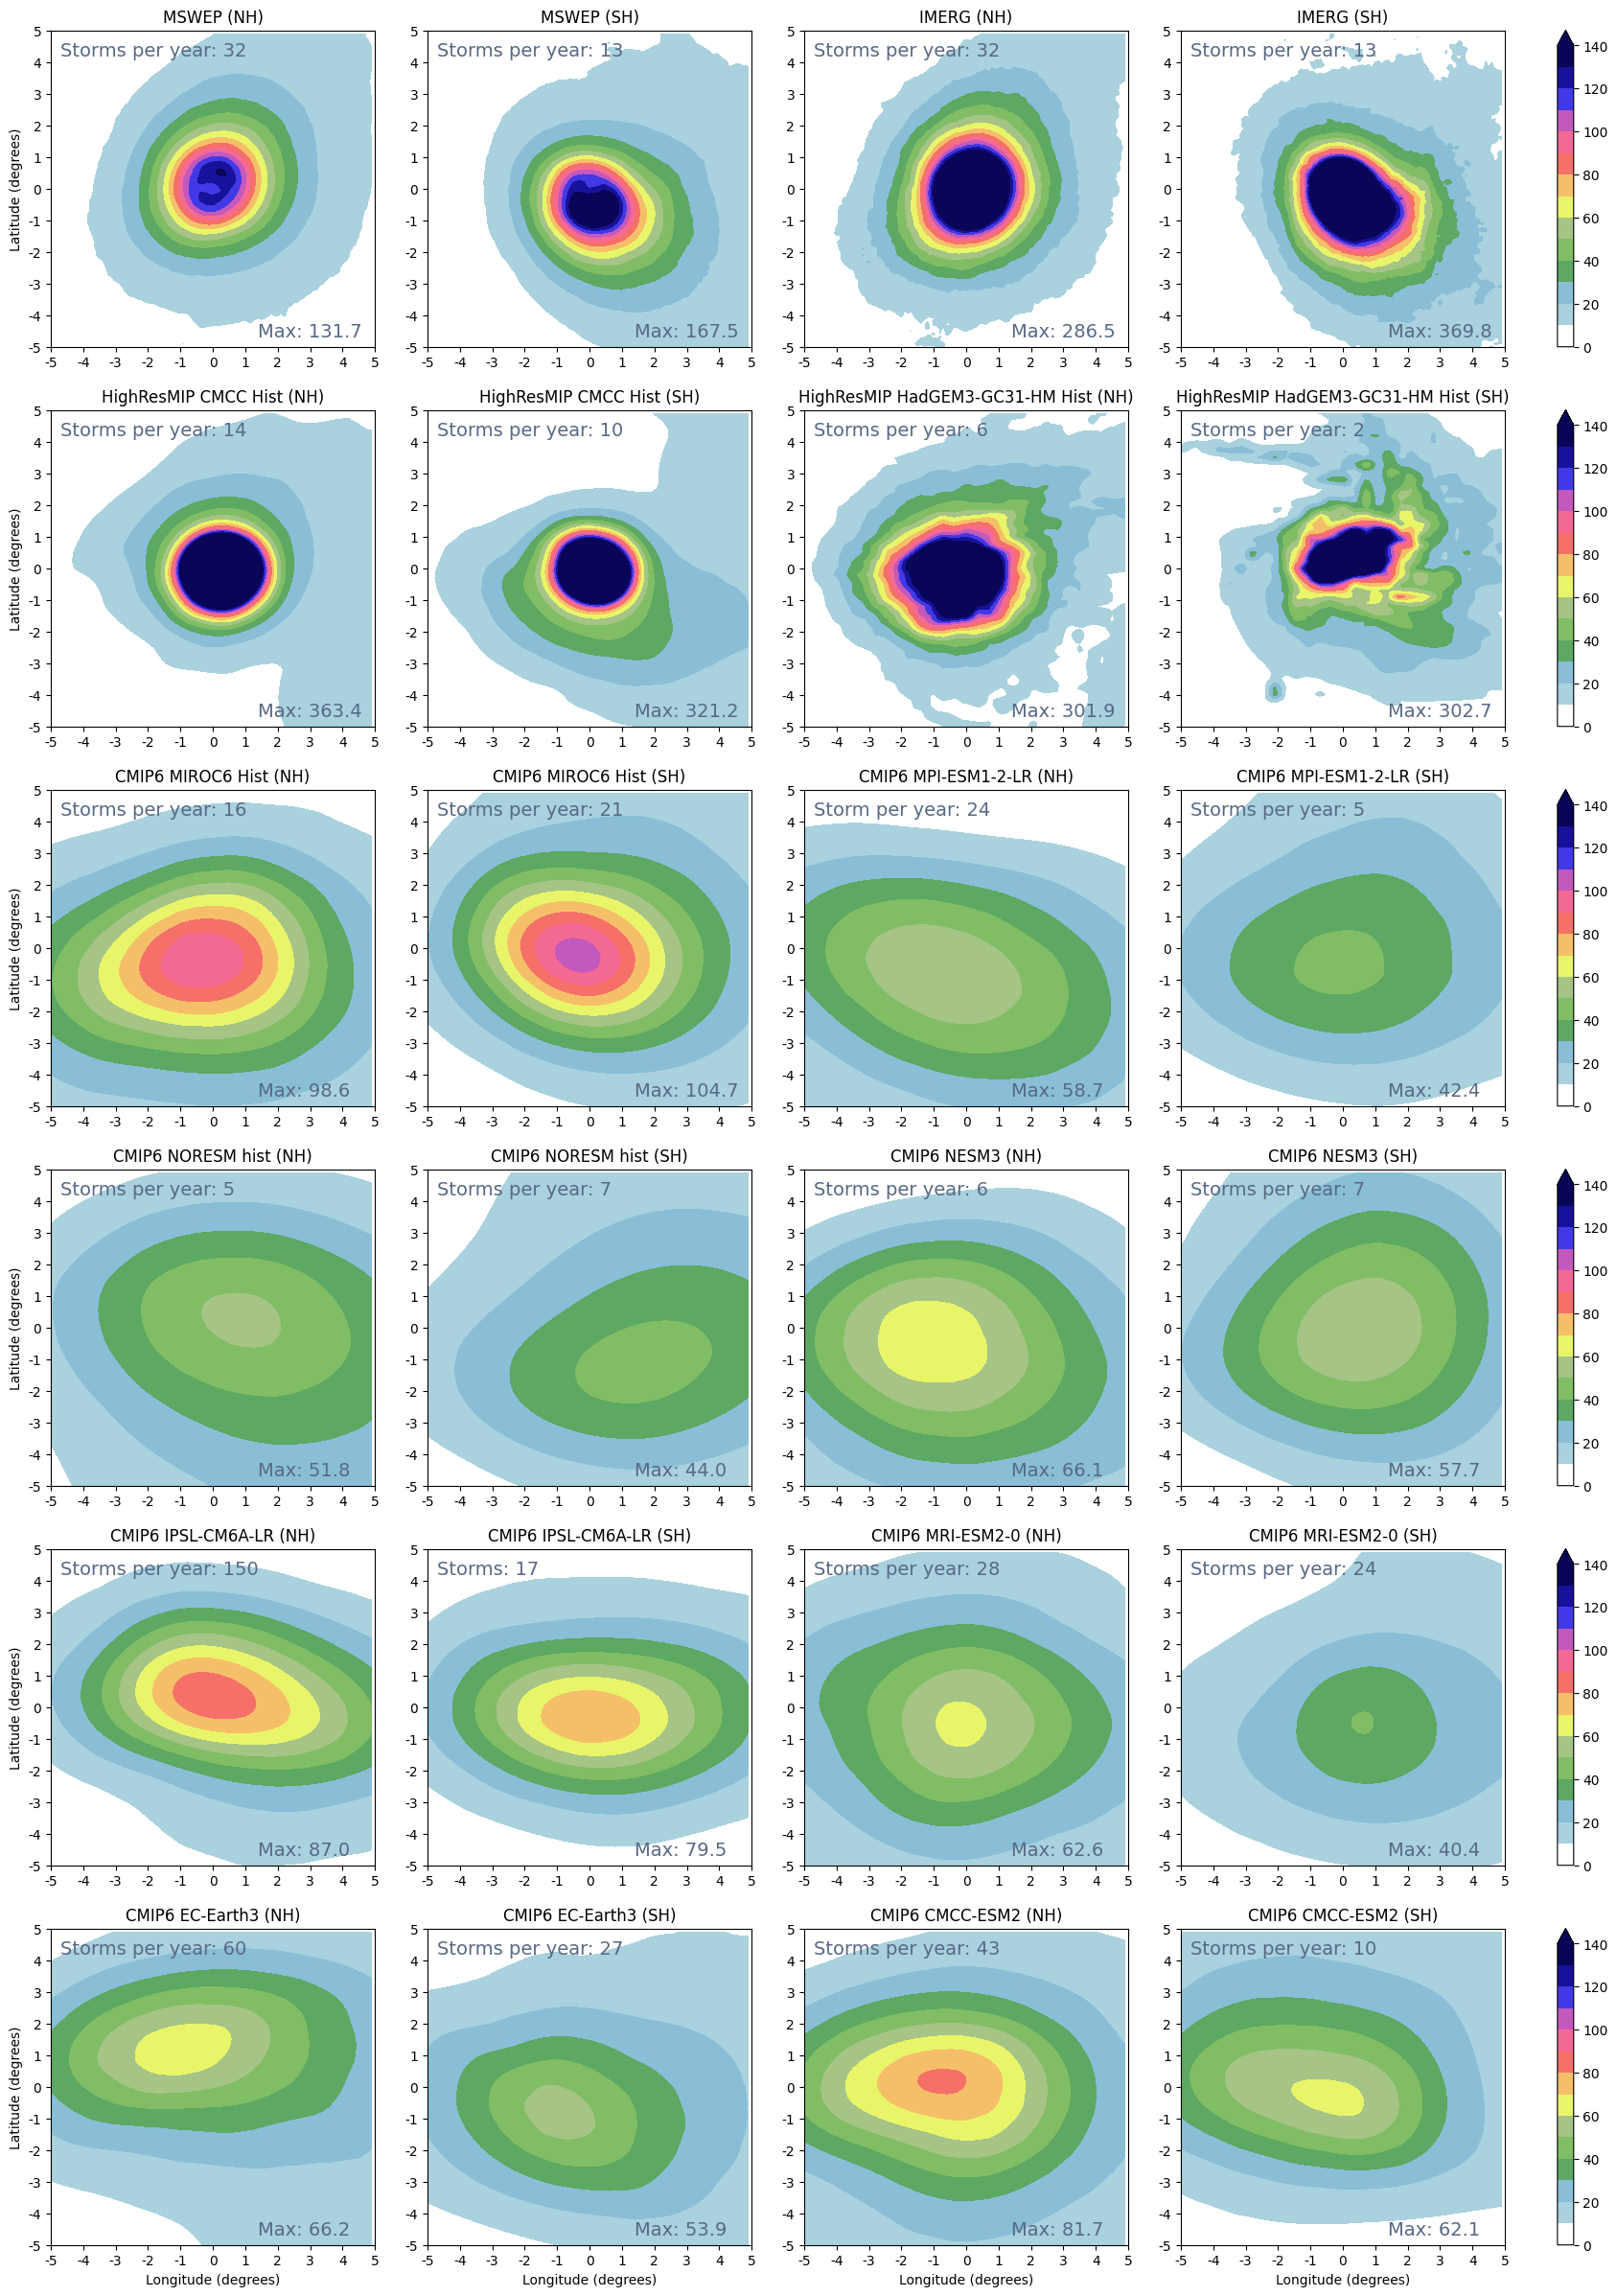

In [12]:

fig,axes = plt.subplots(6,5,figsize=(20.5, 30),gridspec_kw={'width_ratios': [1, 1, 1, 1, 0.05]})
levels = [0,10,20,30,40,50,60,70,80,90,100,110,120,130,140]
# levels = [0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,160,180,200,220,240]

# MSWEP Obs
# im = axes[0,0].contourf(composite_nh,cmap=precip_cmap,levels=levels,extend='max')
# axes[0,0].annotate('Max: %.1f' % np.max(composite_nh), xy = (90,90), xytext=(64,3),fontsize=14, color='#586985')
# axes[0,0].annotate('Storms: %.0f' % nstorms_nh, xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')
# # axes[0,0].annotate('Storms per year: %.0f' % (int(nstorms_nh) / nyea), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')
# im_2 = axes[0,1].contourf(composite_sh,cmap=precip_cmap,levels=levels,extend='max')
# axes[0,1].annotate('Max: %.1f' % np.max(composite_sh), xy = (90,90), xytext=(64,3),fontsize=14, color='#586985')
# axes[0,1].annotate('Storms: %.0f' % nstorms_sh, xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')

# # MSWEP Obs
axes[0,0].contourf(composite_mswep_NH,cmap=precip_cmap,levels=levels,extend='max')
axes[0,0].annotate('Max: %.1f' % np.max(composite_mswep_NH), xy = (90,90), xytext=(64,3),fontsize=14, color='#586985')
axes[0,0].annotate('Storms per year: %.0f' % (int(nstorms_mswep_nh) / nyears_mswep), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')
im = axes[0,1].contourf(composite_mswep_SH,cmap=precip_cmap,levels=levels,extend='max')
axes[0,1].annotate('Max: %.1f' % np.max(composite_mswep_SH), xy = (90,90), xytext=(64,3),fontsize=14, color='#586985')
axes[0,1].annotate('Storms per year: %.0f' % (int(nstorms_mswep_sh) / nyears_mswep), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')

# # IMERG Obs
axes[0,2].contourf(composite_imerg_NH,cmap=precip_cmap,levels=levels,extend='max')
axes[0,2].annotate('Max: %.1f' % np.max(composite_imerg_NH), xy = (90,90), xytext=(64,3),fontsize=14, color='#586985')
axes[0,2].annotate('Storms per year: %.0f' % (int(nstorms_mswep_nh) / nyears_mswep), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')
im_6 = axes[0,3].contourf(composite_imerg_SH,cmap=precip_cmap,levels=levels,extend='max')
axes[0,3].annotate('Max: %.1f' % np.max(composite_imerg_SH), xy = (90,90), xytext=(64,3),fontsize=14, color='#586985')
axes[0,3].annotate('Storms per year: %.0f' % (int(nstorms_mswep_sh) / nyears_mswep), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')

# HighresMIP
im_5 = axes[1,0].contourf(composite_CMCC_hist_NH,cmap=precip_cmap,levels=levels,extend='max')
axes[1,0].annotate('Max: %.1f' % np.max(composite_CMCC_hist_NH), xy = (90,90), xytext=(64,3),fontsize=14, color='#586985')
axes[1,0].annotate('Storms per year: %.0f' % (int(nstorms_CMCC_hist_nh) / nyears_CMCC_hist_NH), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')
im_6 = axes[1,1].contourf(composite_CMCC_hist_SH,cmap=precip_cmap,levels=levels,extend='max')
axes[1,1].annotate('Max: %.1f' % np.max(composite_CMCC_hist_SH), xy = (90,90), xytext=(64,3),fontsize=14, color='#586985')
axes[1,1].annotate('Storms per year: %.0f' % (int(nstorms_CMCC_hist_sh) / nyears_CMCC_hist_SH) , xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')

axes[1,2].contourf(composite_hadgem_hist_NH,cmap=precip_cmap,levels=levels,extend='max')
axes[1,2].annotate('Max: %.1f' % np.max(composite_hadgem_hist_NH), xy = (90,90), xytext=(64,3),fontsize=14, color='#586985')
axes[1,2].annotate('Storms per year: %.0f' % (int(nstorms_hadgem_hist_nh) / nyears_hadgem_hist_NH), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')
axes[1,3].contourf(composite_hadgem_hist_SH,cmap=precip_cmap,levels=levels,extend='max')
axes[1,3].annotate('Max: %.1f' % np.max(composite_hadgem_hist_SH), xy = (90,90), xytext=(64,3),fontsize=14, color='#586985')
axes[1,3].annotate('Storms per year: %.0f' % (int(nstorms_hadgem_hist_sh) / nyears_hadgem_hist_SH), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')


# CMIP6 hist
axes[2,0].contourf(composite_miroc6_hist_nh,cmap=precip_cmap,levels=levels,extend='max')
axes[2,0].annotate('Max: %.1f' % np.max(composite_miroc6_hist_nh), xy = (90,90), xytext=(64,3),fontsize=14, color='#586985')
axes[2,0].annotate('Storms per year: %.0f' % (int(nstorms_miroc6_hist_nh) / nyears_miroc6_hist_nh), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')
axes[2,1].contourf(composite_miroc6_hist_sh,cmap=precip_cmap,levels=levels,extend='max')
axes[2,1].annotate('Max: %.1f' % np.max(composite_miroc6_hist_sh), xy = (90,90), xytext=(64,3),fontsize=14, color='#586985')
axes[2,1].annotate('Storms per year: %.0f' % (int(nstorms_miroc6_hist_sh) / nyears_miroc6_hist_sh), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')

axes[2,2].contourf(composite_mpi_hist_nh,cmap=precip_cmap,levels=levels,extend='max')
axes[2,2].annotate('Max: %.1f' % np.max(composite_mpi_hist_nh), xy = (90,90), xytext=(64,3),fontsize=14, color='#586985')
axes[2,2].annotate('Storm per year: %.0f' % (int(nstorms_mpi_hist_nh) / nyears_mpi_hist_nh), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')
axes[2,3].contourf(composite_mpi_hist_sh,cmap=precip_cmap,levels=levels,extend='max')
axes[2,3].annotate('Max: %.1f' % np.max(composite_mpi_hist_sh), xy = (90,90), xytext=(64,3),fontsize=14, color='#586985')
axes[2,3].annotate('Storms per year: %.0f' % (int(nstorms_mpi_hist_sh) / nyears_mpi_hist_sh), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')

axes[3,0].contourf(composite_noresm_hist_nh,cmap=precip_cmap,levels=levels,extend='max')
axes[3,0].annotate('Max: %.1f' % np.max(composite_noresm_hist_nh), xy = (90,90), xytext=(64,3),fontsize=14, color='#586985')
axes[3,0].annotate('Storms per year: %.0f' % (int(nstorms_noresm_hist_nh) / nyears_noresm_hist_nh), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')
axes[3,1].contourf(composite_noresm_hist_sh,cmap=precip_cmap,levels=levels,extend='max')
axes[3,1].annotate('Max: %.1f' % np.max(composite_noresm_hist_sh), xy = (90,90), xytext=(64,3),fontsize=14, color='#586985')
axes[3,1].annotate('Storms per year: %.0f' % (int(nstorms_noresm_hist_sh) / nyears_noresm_hist_sh), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')

axes[3,2].contourf(composite_nesm_hist_nh,cmap=precip_cmap,levels=levels,extend='max')
axes[3,2].annotate('Max: %.1f' % np.max(composite_nesm_hist_nh), xy = (90,90), xytext=(64,3),fontsize=14, color='#586985')
axes[3,2].annotate('Storms per year: %.0f' % (int(nstorms_nesm_hist_nh) / nyears_nesm_hist_nh), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')
axes[3,3].contourf(composite_nesm_hist_sh,cmap=precip_cmap,levels=levels,extend='max')
axes[3,3].annotate('Max: %.1f' % np.max(composite_nesm_hist_sh), xy = (90,90), xytext=(64,3),fontsize=14, color='#586985')
axes[3,3].annotate('Storms per year: %.0f' % (int(nstorms_nesm_hist_sh) / nyears_nesm_hist_sh), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')

axes[4,0].contourf(composite_ipsl_hist_nh,cmap=precip_cmap,levels=levels,extend='max')
axes[4,0].annotate('Max: %.1f' % np.max(composite_ipsl_hist_nh), xy = (90,90), xytext=(64,3),fontsize=14, color='#586985')
axes[4,0].annotate('Storms per year: %.0f' % (int(nstorms_ipsl_hist_nh) / nyears_ipsl_hist_nh), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')
axes[4,1].contourf(composite_ipsl_hist_sh,cmap=precip_cmap,levels=levels,extend='max')
axes[4,1].annotate('Max: %.1f' % np.max(composite_ipsl_hist_sh), xy = (90,90), xytext=(64,3),fontsize=14, color='#586985')
axes[4,1].annotate('Storms: %.0f' % (int(nstorms_ipsl_hist_sh) / nyears_ipsl_hist_sh), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')

axes[4,2].contourf(composite_mri_hist_nh,cmap=precip_cmap,levels=levels,extend='max')
axes[4,2].annotate('Max: %.1f' % np.max(composite_mri_hist_nh), xy = (90,90), xytext=(64,3),fontsize=14, color='#586985')
axes[4,2].annotate('Storms per year: %.0f' % (int(nstorms_mri_hist_nh) / nyears_mri_hist_nh), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')
axes[4,3].contourf(composite_mri_hist_sh,cmap=precip_cmap,levels=levels,extend='max')
axes[4,3].annotate('Max: %.1f' % np.max(composite_mri_hist_sh), xy = (90,90), xytext=(64,3),fontsize=14, color='#586985')
axes[4,3].annotate('Storms per year: %.0f' % (int(nstorms_mri_hist_sh) / nyears_mri_hist_sh), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')

axes[5,0].contourf(composite_ecearth_hist_nh,cmap=precip_cmap,levels=levels,extend='max')
axes[5,0].annotate('Max: %.1f' % np.max(composite_ecearth_hist_nh), xy = (90,90), xytext=(64,3),fontsize=14, color='#586985')
axes[5,0].annotate('Storms per year: %.0f' % (int(nstorms_ecearth_hist_nh) / nyears_ecearth_hist_nh), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')
axes[5,1].contourf(composite_ecearth_hist_sh,cmap=precip_cmap,levels=levels,extend='max')
axes[5,1].annotate('Max: %.1f' % np.max(composite_ecearth_hist_sh), xy = (90,90), xytext=(64,3),fontsize=14, color='#586985')
axes[5,1].annotate('Storms per year: %.0f' % (int(nstorms_ecearth_hist_sh) / nyears_ecearth_hist_sh), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')

axes[5,2].contourf(composite_cmcclr_hist_nh,cmap=precip_cmap,levels=levels,extend='max')
axes[5,2].annotate('Max: %.1f' % np.max(composite_cmcclr_hist_nh), xy = (90,90), xytext=(64,3),fontsize=14, color='#586985')
axes[5,2].annotate('Storms per year: %.0f' % (int(nstorms_cmcclr_hist_nh) / nyears_cmcclr_hist_nh), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')
axes[5,3].contourf(composite_cmcclr_hist_sh,cmap=precip_cmap,levels=levels,extend='max')
axes[5,3].annotate('Max: %.1f' % np.max(composite_cmcclr_hist_sh), xy = (90,90), xytext=(64,3),fontsize=14, color='#586985')
axes[5,3].annotate('Storms per year: %.0f' % (int(nstorms_cmcclr_hist_sh) / nyears_cmcclr_hist_sh), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')

# Set the tick positions
t_p = [0,10,20,30,40,50,60,70,80,90,100]
t_l = [-5,-4,-3,-2,-1,0,1,2,3,4,5]
for i in range(6):
	for j in range(4):
		axes[i,j].set_xticks(t_p)
		axes[i,j].set_yticks(t_p)
		# Set the tick labels
		axes[i,j].set_xticklabels(t_l)
		axes[i,j].set_yticklabels(t_l)


for ax in [axes[0,0],axes[1,0],axes[2,0],axes[3,0],axes[4,0],axes[5,0]]:
	ax.set_ylabel('Latitude (degrees)')
for ax in [axes[5,0],axes[5,1],axes[5,2],axes[5,3]]:
	ax.set_xlabel('Longitude (degrees)')

axes[0,0].set_title('MSWEP (NH)')
axes[0,1].set_title('MSWEP (SH)')
# axes[0,1].set_xlabel('Longitude (degrees)')
# add **font to change font

# axes[0,2].set_title('MSWEP extreme 100 (NH)')
# axes[0,3].set_title('MSWEP extreme 100 (SH)')

axes[0,2].set_title('IMERG (NH)')
axes[0,3].set_title('IMERG (SH)')
# axes[1,2].set_title('IMERG extreme 100 (NH)')
# axes[1,3].set_title('IMERG extreme 100 (SH)')

# axes[2,0].set_title('TRMM (NH)')
# axes[2,1].set_title('TRMM (SH)')
# axes[2,2].set_title('TRMM extreme 100 (NH)')
# axes[2,3].set_title('TRMM extreme 100 (SH)')

axes[1,0].set_title('HighResMIP CMCC Hist (NH)')
axes[1,1].set_title('HighResMIP CMCC Hist (SH)')
# axes[1,2].set_title('HighResMIP EC-Earth-3P-HR Hist (NH)')
# axes[1,3].set_title('HighResMIP EC-Earth-3P-HR Hist (SH)')
axes[1,2].set_title('HighResMIP HadGEM3-GC31-HM Hist (NH)')
axes[1,3].set_title('HighResMIP HadGEM3-GC31-HM Hist (SH)')

axes[2,0].set_title('CMIP6 MIROC6 Hist (NH)')
axes[2,1].set_title('CMIP6 MIROC6 Hist (SH)')
axes[2,2].set_title('CMIP6 MPI-ESM1-2-LR (NH)')
axes[2,3].set_title('CMIP6 MPI-ESM1-2-LR (SH)')

axes[3,0].set_title('CMIP6 NORESM hist (NH)')
axes[3,1].set_title('CMIP6 NORESM hist (SH)')
axes[3,2].set_title('CMIP6 NESM3 (NH)')
axes[3,3].set_title('CMIP6 NESM3 (SH)')

axes[4,0].set_title('CMIP6 IPSL-CM6A-LR (NH)')
axes[4,1].set_title('CMIP6 IPSL-CM6A-LR (SH)')
axes[4,2].set_title('CMIP6 MRI-ESM2-0 (NH)')
axes[4,3].set_title('CMIP6 MRI-ESM2-0 (SH)')

axes[5,0].set_title('CMIP6 EC-Earth3 (NH)')
axes[5,1].set_title('CMIP6 EC-Earth3 (SH)')
axes[5,2].set_title('CMIP6 CMCC-ESM2 (NH)')
axes[5,3].set_title('CMIP6 CMCC-ESM2 (SH)')

# axes[8,0].set_title('2D WGAN (NH)')
# axes[8,1].set_title('2D WGAN (SH)')
# axes[8,2].set_title('2D WGAN extreme (NH)')
# axes[8,3].set_title('2D WGAN extreme (SH)')

# axes[9,0].set_title('Scalar WGAN applied to ERA5 (NH)')
# axes[9,1].set_title('Scalar WGAN applied to ERA5 (SH)')
# axes[9,2].set_title('Scalar WGAN extreme applied to ERA5 (NH)')
# axes[9,3].set_title('Scalar WGAN extreme applied to ERA5 (SH)')


plt.colorbar(im,ticks=[0,20,40,60,80,100,120,140],cax=axes[0,4])
plt.colorbar(im,ticks=[0,20,40,60,80,100,120,140],cax=axes[1,4])
plt.colorbar(im,ticks=[0,20,40,60,80,100,120,140],cax=axes[2,4])
plt.colorbar(im,ticks=[0,20,40,60,80,100,120,140],cax=axes[3,4])
plt.colorbar(im,ticks=[0,20,40,60,80,100,120,140],cax=axes[4,4])
plt.colorbar(im,ticks=[0,20,40,60,80,100,120,140],cax=axes[5,4])
# plt.colorbar(im,ticks=[0,20,40,60,80,100,120,140],cax=axes[6,4])
# plt.colorbar(im_5,ticks=[0,20,40,60,80,100,120,140],cax=axes[7,4])
# plt.colorbar(im_5,ticks=[0,20,40,60,80,100,120,140],cax=axes[8,4])


plt.savefig('composite_rain5.png',bbox_inches='tight')

In [13]:
# save everything
fig_dir = '/user/home/al18709/work/figures/figure_1/'

# HighresMIP
np.save(fig_dir + 'composite_CMCC_hist_NH.npy',composite_CMCC_hist_NH)
np.save(fig_dir + 'composite_CMCC_hist_SH.npy', composite_CMCC_hist_SH)

np.save(fig_dir + 'composite_ecearthhr_hist_NH.npy',composite_ecearthhr_hist_NH)
np.save(fig_dir + 'composite_ecearthhr_hist_SH.npy',composite_ecearthhr_hist_SH)

np.save(fig_dir + 'composite_hadgem_hist_NH.npy',composite_hadgem_hist_NH)
np.save(fig_dir + 'composite_hadgem_hist_SH.npy',composite_hadgem_hist_SH)

# CMIP6 hist
np.save(fig_dir + 'composite_miroc6_hist_nh.npy',composite_miroc6_hist_nh)
np.save(fig_dir + 'composite_miroc6_hist_sh.npy',composite_miroc6_hist_sh)

np.save(fig_dir + 'composite_mpi_hist_nh.npy',composite_mpi_hist_nh)
np.save(fig_dir + 'composite_mpi_hist_sh.npy',composite_mpi_hist_sh)

np.save(fig_dir + 'composite_noresm_hist_nh.npy',composite_noresm_hist_nh)
np.save(fig_dir + 'composite_noresm_hist_sh.npy',composite_noresm_hist_sh)

# np.save(fig_dir + composite_taiesm_hist_nh,'composite_taiesm_hist_nh.npy')
# np.save(fig_dir + composite_taiesm_hist_sh,'composite_taiesm_hist_sh.npy')

np.save(fig_dir + 'composite_ipsl_hist_nh.npy',composite_ipsl_hist_nh)
np.save(fig_dir + 'composite_ipsl_hist_sh.npy',composite_ipsl_hist_sh)

np.save(fig_dir + 'composite_mri_hist_nh.npy',composite_mri_hist_nh)
np.save(fig_dir + 'composite_mri_hist_sh.npy',composite_mri_hist_sh)

np.save(fig_dir + 'composite_ecearth_hist_nh.npy',composite_ecearth_hist_nh)
np.save(fig_dir + 'composite_ecearth_hist_sh.npy',composite_ecearth_hist_sh)

np.save(fig_dir + 'composite_cmcclr_hist_nh.npy',composite_cmcclr_hist_nh)
np.save(fig_dir + 'composite_cmcclr_hist_sh.npy',composite_cmcclr_hist_sh)

# np.save(fig_dir + composite_bcc_hist_nh,'composite_bcc_hist_nh.npy')
# np.save(fig_dir + composite_bcc_hist_sh,'composite_bcc_hist_sh.npy')

np.save(fig_dir + 'composite_nems_hist_nh.npy',composite_nesm_hist_nh)
np.save(fig_dir + 'composite_nems_hist_sh.npy',composite_nesm_hist_sh)


# OG WGAN
# np.save(composite_og_nh,'composite_og_nh.npy')
# np.save(composite_og_sh,'composite_og_sh.npy')
# np.save(composite_og_x_nh,'composite_og_x_nh.npy')
# np.save(composite_og_x_nh,'composite_og_x_nh.npy')
# np.save(composite_og_x_sh,'composite_og_x_sh.npy')

# # Scalar WGAN
# np.save(composite_wgan_nh,'composite_wgan_nh.npy')
# np.save(composite_wgan_sh,'composite_wgan_sh.npy')
